# Titanic: Machine Learning from Disaster

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## Load the data

In [109]:
# Load and have a look at the dataset
df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Get to understand the dataset

In [110]:
# Number of rows
total_rows = df["PassengerId"].count()
print( "Train data contains %d rows\n" % total_rows )

# Missing data
for col in df.columns:
    nb_rows = df[col].count()
    print("Column {:<12s} has {:>3d}/{:<3d} missing values".format( col, total_rows - nb_rows, total_rows ) )

Train data contains 891 rows

Column PassengerId  has   0/891 missing values
Column Survived     has   0/891 missing values
Column Pclass       has   0/891 missing values
Column Name         has   0/891 missing values
Column Sex          has   0/891 missing values
Column Age          has 177/891 missing values
Column SibSp        has   0/891 missing values
Column Parch        has   0/891 missing values
Column Ticket       has   0/891 missing values
Column Fare         has   0/891 missing values
Column Cabin        has 687/891 missing values
Column Embarked     has   2/891 missing values


### A first analysis of data quality shows that
- Cabin column has too many missing data
- Age information also has many misssing data but it is acceptable
- Embarked has only 2 missing value
- The name column seems has very random information
- The ticket column also contains very random information

# First step of preprocessing
- In thse step, we will remove some useless columns
- Simply remove several missing value rows

### Drop columns
Drop the Name & Ticket columns since the information in these columns are all random information

In [111]:
# Remove 'Name' and 'Ticket' column
def drop_columns(df):
    df = df.drop('Name', 1)
    df = df.drop('Ticket', 1)
    df = df.drop('PassengerId', 1)
    return df

df = drop_columns(df)
test_df = drop_columns(test_df)

### Apply 2 missing value rows with U

In [112]:
# Apply 2 missing value rows with U
df.Embarked[df.Embarked.isnull()] = 'U'
test_df.Embarked[test_df.Embarked.isnull()] = 'U'

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Second Step of Preprocessing
- For Fare column, one person may buy more then one tickets, so their price is high, we need to find the fare for one person

In [113]:
def process_fare(df):
    fare_df = df
    cabins = list(fare_df.Cabin)
    nb_cabins = [len(str(cabin).split(" ")) for cabin in cabins]
    fare_df.Fare = np.array( fare_df.Fare ) / np.array(nb_cabins)
    return fare_df

df = process_fare(df)
test_df = process_fare(test_df)

# Third Step of preprocessing
- Feature transformation for Cabin column
- Label NaN with unknown cabin category
- Deal with missing value rows in age

## Deal with the Cabin column
We will do some feature transformation for Cabin column, only keep the first letter since the first letter seems to be the category of cabin i.e.
- C85 -> C
- E10 -> E
- ...

We will also tranform the NaN as 'U' for processing

In [114]:
def process_cabin(df):
    cabin_df = df[df.Cabin.notnull()]
    cabins = list(cabin_df.Cabin)
    cabins = [cabin[0] for cabin in cabins]
    cabin_df['Cabin'] = cabins

    # Replace the cabin column with the transformed cabin column
    df.loc[df.index.isin(cabin_df.index), df.columns] = cabin_df[df.columns]

    # Replace the NaN as unknown
    df.Cabin[df.Cabin.isnull()] = 'U'
    
    return df

df = process_cabin(df)
test_df = process_cabin(test_df)

# After processing, the data frame becomes
df.head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,U,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,U,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,U,S


### Dive into Cabin Column and have a look at the cabin - survival relation 

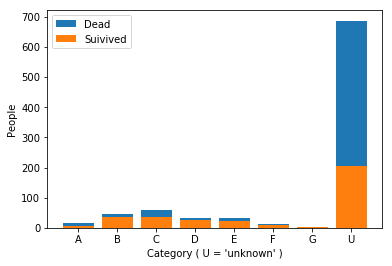

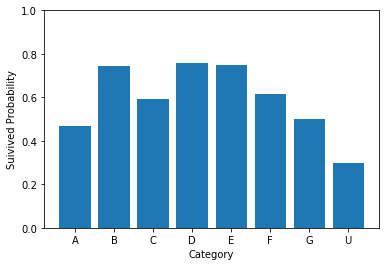

In [115]:
cabin_dead_df     = df[df.Survived==0].groupby(['Cabin'], as_index=False)['Survived'].count()
cabin_survived_df = df[df.Survived==1].groupby(['Cabin'], as_index=False)['Survived'].count()

cabin_dead_df     = cabin_dead_df    [["Cabin", "Survived"]]
cabin_survived_df = cabin_survived_df[["Cabin", "Survived"]]

# Rename dead data frame for disambuiguation
cabin_dead_df.columns =  ["Cabin", "Not_Survived"]

# Merge two data frame by joining on Cabin category
merged_cabin_df = pd.merge(cabin_dead_df, cabin_survived_df, on='Cabin')

cabin_categories = merged_cabin_df.Cabin
totals      = merged_cabin_df.Survived + merged_cabin_df.Not_Survived
survivals   = merged_cabin_df.Survived
percentages = survivals / totals

# First figure shows the dead vs survived
plt.figure()
plt.bar( np.arange(len(cabin_categories)), totals,    label="Dead"     )
plt.bar( np.arange(len(cabin_categories)), survivals, label="Suivived")

plt.xlabel("Category ( U = 'unknown' )")
plt.ylabel("People")
plt.xticks(np.arange(len(cabin_categories)), cabin_categories)
plt.legend()

# Second figure shows the surviving percentage
plt.figure()
plt.bar( np.arange(len(cabin_categories)), percentages )

plt.xlabel("Category")
plt.ylabel("Suivived Probability")
plt.ylim((0.0, 1.0))
plt.xticks(np.arange(len(cabin_categories)), cabin_categories)
plt.show()

# Forth Step of Preprocessing
- Parse string into numeric value for column Cabin, Sex and Embarked

In [116]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df.Sex)
df.Sex = le.transform(df.Sex)
test_df.Sex = le.transform(test_df.Sex)

le = preprocessing.LabelEncoder()
le.fit(df.Cabin)
df.Cabin = le.transform(df.Cabin)
test_df.Cabin = le.transform(test_df.Cabin)

le = preprocessing.LabelEncoder()
le.fit(df.Embarked)
df.Embarked = le.transform(df.Embarked)
test_df.Embarked = le.transform(test_df.Embarked)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,8,2
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,8,2
3,1,1,0,35.0,1,0,53.1000,2,2
4,0,3,1,35.0,0,0,8.0500,8,2


# Fifth Step of Preprocessing

## Deal with the Age column
- It's better that we group some ages together into a categories before doing the machine learning
- Age column has around 173/891 missing values, it's a pity if we remove these rows directly, but simpley fill this row with averange value is not a good idea, so I choose to use existing data's other columns to predict the age value and fill with the predicted value.

In [117]:
age_df = df
age_df.Age = np.array(df.Age) // 10

df = age_df
test_df.Age = np.array(test_df.Age) // 10

age_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,2.0,1,0,7.2500,8,2
1,1,1,0,3.0,1,0,71.2833,2,0
2,1,3,0,2.0,0,0,7.9250,8,2
3,1,1,0,3.0,1,0,53.1000,2,2
4,0,3,1,3.0,0,0,8.0500,8,2


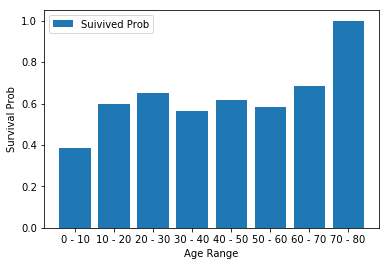

In [118]:
# See the age and the corrsponding survival situation
age_df = df[df.Age.notnull()][['Survived', 'Age']]

# Split into two parts: survived and dead
survived_age = age_df[ age_df.Survived == 0 ]['Age']
dead_age     = age_df[ age_df.Survived == 1 ]['Age']

# Count their age distribution
survived_age_count = Counter(survived_age)
dead_age_count     = Counter(dead_age)

# Compute the count for each age distribution
ages           = np.arange(df.Age.max() )
survived_count = [ survived_age_count[age] for age in ages ]
dead_count     = [ dead_age_count    [age] for age in ages ]

# Use Bar chart to plot them
plt.bar(ages, survived_count / np.add( survived_count, dead_count ), label="Suivived Prob" )

plt.xlabel("Age Range")
plt.ylabel("Survival Prob")
plt.legend()

xticks = []
for i in ages:
    xticks.append("%d - %d" % ( i * 10, i*10 + 10 ) )
plt.xticks(ages, xticks)
plt.show()

### Predict missing age values using other columns

In [119]:
def process_age(df):
    train_df = df[df.Age.notnull()]
    features = train_df.drop('Age', axis=1)
    targets  = np.array(train_df.Age)

    from sklearn.ensemble import GradientBoostingClassifier

    clf = SVC()
    clf.fit(features, targets)

    # Fill data frame
    pred_df = df[df.Age.isnull() ]
    pred_df = pred_df.drop('Age', axis=1)
    pred_df['Age'] = clf.predict(pred_df)

    # Replace the cabin column with the transformed cabin column
    df.loc[df.index.isin(pred_df.index), df.columns] = pred_df[df.columns]
    
    return df

df = process_age(df)
test_df.Fare[test_df.Fare.isnull()] = test_df.Fare.mean()
test_df = process_age(test_df)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## After preprocessing, the processed data becomes

In [120]:
# Train data
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,2.0,1,0,7.2500,8,2
1,1,1,0,3.0,1,0,71.2833,2,0
2,1,3,0,2.0,0,0,7.9250,8,2
3,1,1,0,3.0,1,0,53.1000,2,2
4,0,3,1,3.0,0,0,8.0500,8,2


In [121]:
# Test data
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,3.0,0,0,7.8292,8,1
1,3,0,4.0,1,0,7.0000,8,2
2,2,1,6.0,0,0,9.6875,8,1
3,3,1,2.0,0,0,8.6625,8,2
4,3,0,2.0,1,1,12.2875,8,2


# Build and Compare Prediction Model

### Random aplit train data into train and test

In [122]:
msk = np.random.rand(len(df)) < 0.8

# Train
train = df[msk]

# Test
test = df[~msk]

### Use SVM to classify the result

In [123]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

x = train.drop("Survived", axis=1)
y = train.Survived

clf = SVC()
clf.fit(x, y)

x_ = test.drop("Survived", axis=1)
y_ = test.Survived

y_pred = clf.predict(x_)

accuracy_score(y_, y_pred)

0.7344632768361582

### Use Decision Tree to classify the result

In [124]:
from sklearn import tree
from sklearn.metrics import accuracy_score

x = train.drop("Survived", axis=1)
y = train.Survived

clf = tree.DecisionTreeClassifier()
clf.fit(x, y)

x_ = test.drop("Survived", axis=1)
y_ = test.Survived

y_pred = clf.predict(x_)

accuracy_score(y_, y_pred)

0.81355932203389836

### Use Logistic Regression to classify the result

In [125]:
from sklearn.linear_model import LogisticRegression

x = train.drop("Survived", axis=1)
y = train.Survived

clf = LogisticRegression()
clf.fit(x, y)

x_ = test.drop("Survived", axis=1)
y_ = test.Survived

y_pred = clf.predict(x_)

accuracy_score(y_, y_pred)

0.74576271186440679

### Use Naive Bayes to classify the result

In [126]:
from sklearn.naive_bayes import GaussianNB

x = train.drop("Survived", axis=1)
y = train.Survived

clf = GaussianNB()
clf.fit(x, y)

x_ = test.drop("Survived", axis=1)
y_ = test.Survived

y_pred = clf.predict(x_)

accuracy_score(y_, y_pred)

0.74576271186440679

### Use GBDT to classify the result

In [127]:
from sklearn.ensemble import GradientBoostingClassifier

x = train.drop("Survived", axis=1)
y = train.Survived

clf = GradientBoostingClassifier()
clf.fit(x, y)

x_ = test.drop("Survived", axis=1)
y_ = test.Survived

y_pred = clf.predict(x_)

accuracy_score(y_, y_pred)

0.81355932203389836

# Predict final test result
- We find that the GBDT model shows the best performance

In [128]:
from sklearn.ensemble import GradientBoostingClassifier


x = df.drop("Survived", axis=1)
y = df.Survived

clf = GradientBoostingClassifier()
clf.fit(x, y)

y_pred = clf.predict(test_df)

test_df = pd.read_csv("./data/test.csv")
submission_df = pd.DataFrame()
submission_df["PassengerId"] = test_df.PassengerId
submission_df["Survived"] = y_pred

In [129]:
submission_df.to_csv("./data/my_result.csv", index=False)